In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gatspy import periodic

import warnings
warnings.filterwarnings('ignore')

In [2]:
saha = pd.read_csv('392work2.tab', sep = '\s{5}', header = None, 
                   names = ['HJD-2400000.0', 'Magnitude', 'Uncertainty in Magnitude', 'Passband'], engine = 'python')
saha.info()
saha.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 4 columns):
HJD-2400000.0               370 non-null float64
Magnitude                   370 non-null float64
Uncertainty in Magnitude    370 non-null float64
Passband                    370 non-null float64
dtypes: float64(4)
memory usage: 11.6 KB


,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,0.0
1,56423.812500,28.160,0.029,0.0
2,56423.894531,28.089,0.021,0.0
3,56424.718750,27.882,0.024,0.0
4,56424.808594,28.105,0.029,0.0


In [3]:
saha['Passband'] = saha['Passband'].replace({0.0 : 'u', 1.0 : 'g', 2.0 : 'r', 3.0 : 'i', 4.0: 'z'})
saha.head()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,u
1,56423.812500,28.160,0.029,u
2,56423.894531,28.089,0.021,u
3,56424.718750,27.882,0.024,u
4,56424.808594,28.105,0.029,u


In [4]:
saha.tail()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
365,57116.839844,21.776,0.015,z
366,57116.851562,21.850,0.017,z
367,57116.863281,21.840,0.019,z
368,57116.890625,21.875,0.012,z
369,57116.906250,21.879,0.012,z


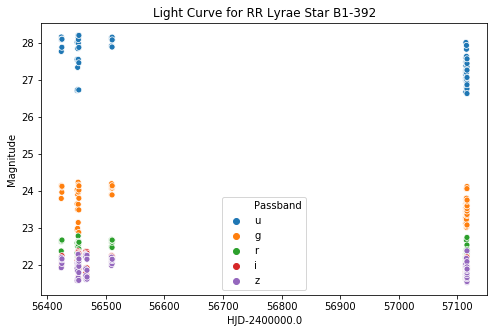

In [5]:
plt.figure(figsize = (8, 5))
plt.title('Light Curve for RR Lyrae Star B1-392')
sns.scatterplot(x = 'HJD-2400000.0', y = 'Magnitude', data = saha, hue = 'Passband');

In [6]:
def phase_dispersion_minimization(times, magnitudes, uncertainties, periods):
    """Implements the formula for calculating the Lafler-Kinman statistic
    for weighted phase dispersion minimization."""
    
    lafler_kinmans = []
    for period in periods:
        
        folded = (times / period) % 1
        ordered = sorted(list(zip(folded, magnitudes, uncertainties)), key = lambda x: x[0])
        unzipped = [list(t) for t in zip(*ordered)]
        measurements, errors = unzipped[1], unzipped[2]
        wrap_measurements = [measurements[-1]] + measurements
        wrap_errors = [errors[-1]] + errors
        
        weights = []
        for i in range(1, len(wrap_errors)):
            weights.append(1 / (wrap_errors[i]**2 + wrap_errors[i - 1]**2))
        
        numerator = []
        for j in range(1, len(wrap_measurements)):
            difference = (wrap_measurements[j] - wrap_measurements[j - 1])**2
            numerator.append(difference * weights[j - 1])
        
        weighted_mean = np.mean(np.array(measurements) * np.array(weights))
        denominator = sum(weights)*sum((np.array(measurements) - weighted_mean)**2)
        lafler_kinman = sum(numerator) / denominator
        lafler_kinmans.append(lafler_kinman)

    return np.array(lafler_kinmans)


def lomb_scargle_analysis(times, magnitudes, uncertainties, min_period = 0.2, max_period = 1.5):
    """Generates the Lomb-Scargle periodogram for a variable star light curve."""
    fit_periods = np.linspace(min_period, max_period, 10000)
    model = periodic.LombScargleFast(fit_period = True)
    model.optimizer.period_range = (min_period, max_period)
    model.fit(times, magnitudes, uncertainties)
    return [fit_periods, model.score(fit_periods)]


def hybrid_statistic(times, magnitudes, uncertainties):
    """Computes the hybrid statistic defined in Saha et al. (2017), and uses it to find the best period."""
    periods, pi = lomb_scargle_analysis(times, magnitudes, uncertainties)
    theta = phase_dispersion_minimization(times, magnitudes, uncertainties, periods)
    hybrid_statistic = 2 * pi / theta
    best_period = periods[np.argmax(hybrid_statistic)]
    return [1 / periods, pi, 2 / theta, hybrid_statistic, best_period]

In [7]:
def filter_data(passband = 'all'):
    """Return light curve data in a specific band."""
    
    if passband == 'all':
        filtered = saha
    else:
        filtered = saha[saha['Passband'] == passband]
        
    epoch = filtered.iloc[:, 0].values
    magnitudes = filtered.iloc[:, 1].values
    magnitude_errors = filtered.iloc[:, 2].values
    return epoch, magnitudes, magnitude_errors


def plot_periodogram(passband = 'all'):
    """Plots Lomb-Scargle, Lafler-Kinman, and hybrid periodograms for variable star light curves."""
    
    epoch, magnitudes, magnitude_errors = filter_data(passband)
    frequencies, ls_powers, lk_powers, hybrid_powers, best_period = hybrid_statistic(epoch, magnitudes, magnitude_errors)
    
    plt.figure()
    plt.xlabel('Frequencies (1 / day)')
    plt.ylabel(r'Power ($\Pi$)')
    plt.title(f'Lomb-Scargle Periodogram for {passband} Passband')
    plt.plot(frequencies, ls_powers)
    
    plt.figure()
    plt.xlabel('Frequencies (1 / day)')
    plt.ylabel(r'Power ($2$ / $\Theta$)')
    plt.title(f'Lafler-Kinman Periodogram for {passband} Passband')
    plt.plot(frequencies, lk_powers)
    
    plt.figure()
    plt.xlabel('Frequencies (1 / day)')
    plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
    plt.title(f'Hybrid Periodogram for {passband} Passband')
    plt.plot(frequencies, hybrid_powers);
    
    return best_period

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best Period is 0.5016301630163016 Days
True Period is 0.501624 Days


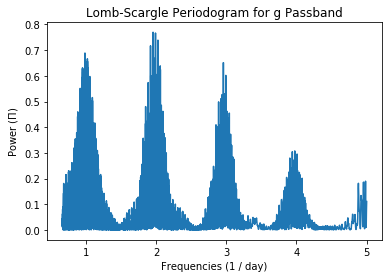

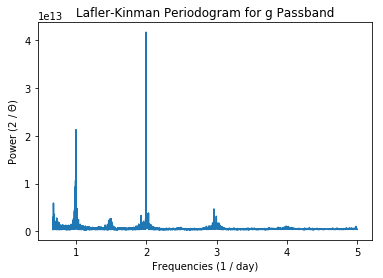

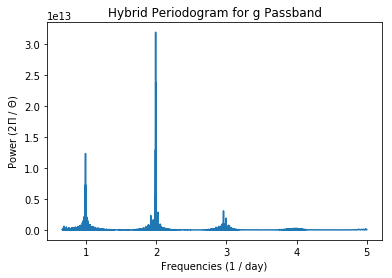

In [8]:
true_period = 0.5016240
best_period = plot_periodogram('g');
print("Best Period is", best_period,  "Days")
print("True Period is", true_period, "Days")

In [9]:
def phase_light_curve(best_period, passband = 'all'):
    """Plots the phased light curve in the specified passband based on the best period."""
    times, magnitudes, magnitude_errors = filter_data(passband)
    phases = (times / best_period) % 1
    
    plt.figure(figsize = (8, 5))
    plt.title('Phased Light Curve for RR Lyrae Star B1-392')
    plt.xlabel('Phase (days)')
    plt.ylabel(r'Magnitude ($m$)')
    plt.scatter(phases, magnitudes, label = f'{passband} filter passband')
    plt.errorbar(phases, magnitudes, yerr = magnitude_errors, linestyle = 'None')
    plt.legend(loc = 'lower right');
    
    return phases

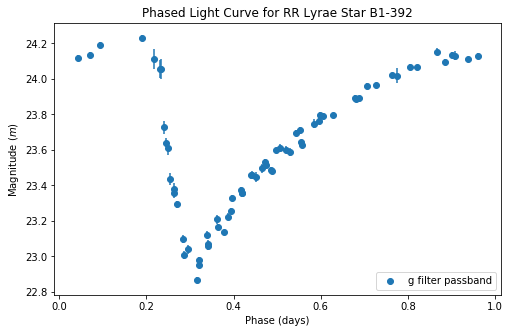

In [10]:
phases = phase_light_curve(best_period, passband = 'g')